In [345]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from hashlib import md5
%matplotlib inline

In [346]:
files = glob.glob('dev_dataset/*')

In [347]:
for i in files:
    if 'augmented.jpg' in i: files.remove(i)

In [348]:
for i in range(len(files)): print(i,files[i])

0 dev_dataset/8.jpg
1 dev_dataset/11_duplicate.jpg
2 dev_dataset/6_similar.jpg
3 dev_dataset/14.jpg
4 dev_dataset/15.jpg
5 dev_dataset/16.jpg
6 dev_dataset/12.jpg
7 dev_dataset/13.jpg
8 dev_dataset/11.jpg
9 dev_dataset/10.jpg
10 dev_dataset/4.jpg
11 dev_dataset/11_modification.jpg
12 dev_dataset/6.jpg
13 dev_dataset/2.jpg
14 dev_dataset/15_modification.jpg
15 dev_dataset/3.jpg
16 dev_dataset/1.jpg
17 dev_dataset/4_similar.jpg
18 dev_dataset/1_duplicate.jpg


In [673]:
first = [0 for i in range(60)]
first.append(1)
np.true_divide(np.sum(first)+1e-10,np.sum(first)+1e-10)

1.0

In [655]:
images = np.array([np.array(Image.open(i).resize((48,48))) for i in files])

In [656]:
def hist(im,bins=50):
    return np.histogram(im,bins=bins)[0]
im_hists = {}
for key,val in enumerate(images):
    im_hists[files[key]] = np.array([hist(val[:,:,0],bins=60),hist(val[:,:,1],bins=60),hist(val[:,:,2],bins=60)])

In [ ]:
im_hists = {}
for key,val in enumerate(images):
    im_hists[files[key]] = np.array([hist(val[:,:,0]),hist(val[:,:,1]),hist(val[:,:,2])])

In [669]:
count = 0
for i,j in combinations(range(len(files)),2):
    diffs = np.zeros((3))
    for k in range(3):
        first = np.minimum(im_hists[files[i]][k],im_hists[files[j]][k])
        diffs[k] = np.true_divide(np.sum(first),np.sum(im_hists[files[j]][k]))
    div = np.mean(diffs)
    if div > 0.81:
        count+=1
        print(files[i],files[j],div)
print(count)

dev_dataset/11_duplicate.jpg dev_dataset/11.jpg 1.0
dev_dataset/11_duplicate.jpg dev_dataset/11_modification.jpg 0.8635706018518517
dev_dataset/6_similar.jpg dev_dataset/6.jpg 0.9098668981481483
dev_dataset/15.jpg dev_dataset/15_modification.jpg 0.9066840277777777
dev_dataset/11.jpg dev_dataset/11_modification.jpg 0.8635706018518517
dev_dataset/4.jpg dev_dataset/4_similar.jpg 0.8517071759259259
dev_dataset/1.jpg dev_dataset/1_duplicate.jpg 1.0
7


In [662]:
files_test = glob.glob('test_dataset/*')
images_new = np.array([np.array(Image.open(i).resize((48,48))) for i in files_test])

In [663]:
im_hists_test = {}
for key,val in enumerate(images_new):
    im_hists_test[files_test[key]] = np.array([hist(val[:,:,0],bins=60),hist(val[:,:,1],bins=60),hist(val[:,:,2],bins=60)])
#     im_hists_test[files_test[key]] = np.array(hist(val))

In [668]:
count = 0
for i,j in combinations(range(len(files_test)),2):
#     diffs = np.zeros((3))
#     for k in range(3):
#         first = np.minimum(im_hists_test[files_test[i]][k],im_hists_test[files_test[j]][k])
#         diffs[k] = np.true_divide(np.sum(first),np.sum(im_hists_test[files_test[j]][k]))
#     div = np.mean(diffs)
    min_el = np.minimum(im_hists_test[files_test[i]],im_hists_test[files_test[j]])
    div = np.true_divide(np.sum(min_el),np.sum(im_hists_test[files_test[j]]))
    if div > 0.81: 
        count+=1
        print(files_test[i][13:19],files_test[j][13:19],div)
print(count)

In [114]:
quantization = np.array([[16,11,10,16,24,40,51,61],
                         [12,12,14,19,26,58,60,55],
                         [14,13,16,24,40,57,69,56],
                         [14,17,22,29,51,87,80,62],
                         [18,22,37,56,68,109,103,77],
                         [24,35,55,64,81,104,113,92],
                         [49,64,78,87,103,121,120,101],
                         [72,92,95,98,112,100,103,99]])

In [337]:
import math
def lambd(x):
    if x == 0: return np.sqrt(1/2)
    return 1
def dct_1d(image):
    DCT_1d = np.zeros_like(image)
    for k in range(image.shape[0]):
        res = 0
        for l in range(image.shape[0]):
            res += image[l]*math.cos(((2*l+1)*math.pi*k)/(2*len(image)))*lambd(k)
        res *= math.sqrt(2/len(image))
        DCT_1d[k] = res
    return DCT_1d
def dct_2d(image):
    DCT_row = np.zeros_like(image)
    DCT = np.zeros_like(image)
    for i in range(image.shape[0]):
        DCT_row[i,:] = dct_1d(image[i,:])
    for j in range(image.shape[1]):
        DCT[:,j] = dct_1d(DCT_row[:,j])
    return DCT

In [338]:
def getDCT(image):
    DCT = np.zeros_like(image)
    for i in range(image.shape[0]//8):
        for j in range(image.shape[1]//8):
            DCT[i:i+8,j:j+8]=np.divide(dct_2d(image[i:i+8,j:j+8]),quantization)
    resize_DCT = DCT[0:8,0:8]
    resize_DCT = resize_DCT>=np.median(resize_DCT.flatten())
    return resize_DCT

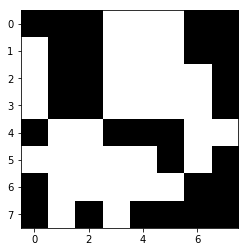

In [343]:
plt.imshow(embeds[files[8]].reshape((8,8)),cmap='bone')

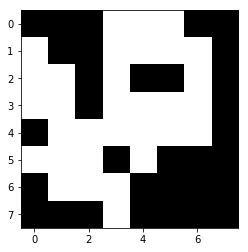

In [344]:
plt.imshow(embeds[files[11]].reshape((8,8)),cmap='bone')

In [633]:
embeds={}
for key,val in enumerate(images_new):
    DCT=getDCT(val)
    embeds[files_test[key]]= DCT.flatten()

In [634]:
def hamming(arr1,arr2):
    return np.count_nonzero(arr1!=arr2)

In [680]:
from itertools import combinations
for i,j in combinations(range(len(files_test)),2):
    distance = hamming(embeds[files_test[i]],embeds[files_test[j]])
    if distance<0.3:
        print('Found distance ',distance,' ',files_test[i],files_test[j])

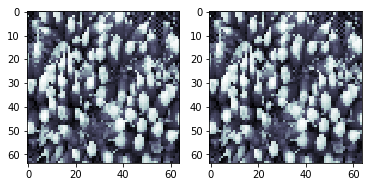

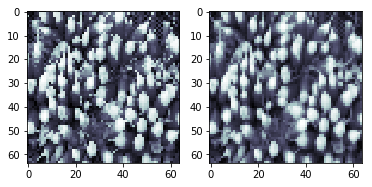

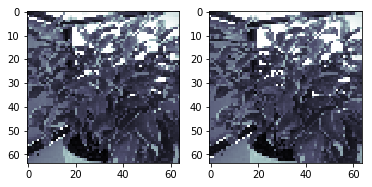

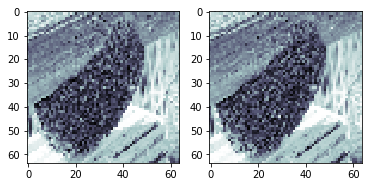

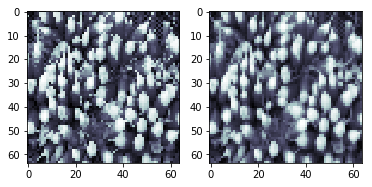

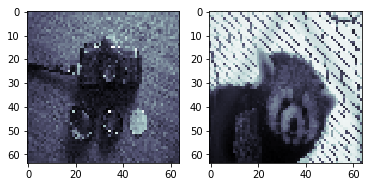

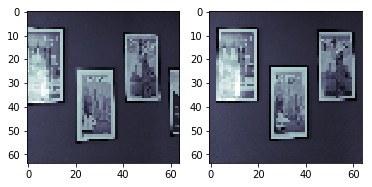

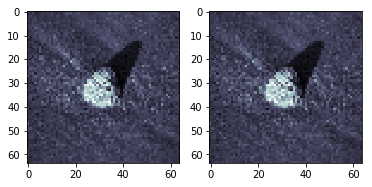

In [510]:
for i,k in dups:
    plt.subplot(121)
    plt.imshow(i,cmap='bone')
    plt.subplot(122)
    plt.imshow(k,cmap='bone')
    plt.show()

In [681]:
def convolve(image,kernel,kernel_size=3,pool=False,pool_size=2):
    new_image = np.zeros_like(image)
    image = np.c_[np.zeros((image.shape[1],1)),image,np.zeros((image.shape[1],1))]
    image = np.r_[np.zeros((1,image.shape[1])),image,np.zeros((1,image.shape[1]))]
    for i in range(image.shape[0]-kernel_size):
        for j in range(image.shape[1]-kernel_size):
            new_image[i,j] = np.sum(image[i:i+kernel_size,j:j+kernel_size]*kernel)
    if pool:
        pooled = np.zeros((new_image.shape[0]//pool_size,new_image.shape[1]//pool_size))
        for i in range(new_image.shape[0]//pool_size):
            for j in range(new_image.shape[1]//pool_size):
                pooled[i,j] = np.max(new_image[i*pool_size:i*pool_size+pool_size,j*pool_size:j*pool_size+pool_size])
        return pooled
    return new_image

def ssim(im1,im2,k1=0.01,k2=0.03):
    dynamic_pix = np.max([im1,im2])
    return ((2*im1.mean()*im2.mean()+(dynamic_pix*k1)**2)*(2*covar(im1.reshape(-1),im2.reshape(-1))+(dynamic_pix*k2)**2))/((im1.mean()**2+im2.mean()**2+(dynamic_pix*k1)**2)*(np.std(im1)**2+ np.std(im2)**2+(dynamic_pix*k2)**2))    

def covar(x,y):
    return np.sum((x-x.mean())*(y-y.mean()))/(x.shape[0]-1)
def ssim_test(im1,im2,k1=0.01,k2=0.02):
    max_val = np.max([im1,im2])
    c1 = (k1*max_val)**2
    c2 = (k2*max_val)**2
    c3 = c2/2
    l = (2*im1.mean()*im2.mean()+c1)/(im1.mean()**2+im2.mean()**2+c1)
    c = (2*im1.std()*im2.std()+c2)/(im1.std()**2+im1.std()**2+c2)
    s = (covar(im1.reshape(-1),im2.reshape(-1))+c3)/(im1.std()*im2.std()+c3)
    return l**1.5*c**1.5*s**2

for i,j in combinations(range(len(files)),2):
    s = ssim_test(files[i],files[j])
    if s > 0.03:
        print(files[i],files[j],s)

In [435]:
img1 = convolve(images[10],fspecial_gauss(3,0.5),kernel_size=3)
img2 = convolve(images[11],fspecial_gauss(3,0.5),kernel_size=3)

In [496]:
img1,img2 = images[1],images[11]
print(ssim_test(img1,img2))
print(compare_ssim(img1,img2))

0.8325126191733035
0.9544363382466361


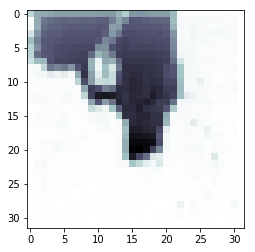

In [338]:
plt.imshow(convolve(images[15],np.array([[-1,-1,-2],[-2,-1,-1],[-2,-2,-1]]),kernel_size=3,pool=True,pool_size=2),cmap='bone')

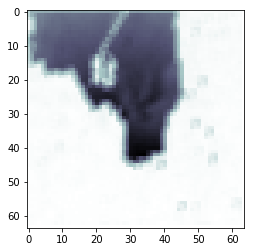

In [339]:
plt.imshow(convolve(images[15],np.array([[-1,-1,-2],[-2,-1,-1],[-2,-2,-1]])),cmap='bone')

In [312]:
for i in range(5):
    a,b=convolve(images[10],np.array([[-1,-1,-2],[-2,-1,-1],[-2,-2,-1]]),3,2),convolve(images[17],np.array([[-1,-1,-2],[-2,-1,-1],[-2,-2,-1]]),3,2)
    print(i,ssim(a,b))

0 0.5849213796275244
1 0.5849213796275244
2 0.5849213796275244
3 0.5849213796275244
4 0.5849213796275244


In [478]:
transformed = []
for i in images:
    transformed.append(convolve(i,np.array([[-1,-1,-2],[-2,-1,-1],[-2,-2,-1]]),3))

In [336]:
for i,j in combinations(range(len(files)),2):
    s = ssim(files[i],files[j])
    if s > 0.65:
        print(files[i],files[j],s)

dev_dataset/11_duplicate.jpg dev_dataset/11.jpg 1.0009775171065498
dev_dataset/11_duplicate.jpg dev_dataset/11_modification.jpg 0.9953318386823862
dev_dataset/6_similar.jpg dev_dataset/6.jpg 0.9142407346406441
dev_dataset/15.jpg dev_dataset/15_modification.jpg 0.993550427012763
dev_dataset/11.jpg dev_dataset/11_modification.jpg 0.9953318386823862
dev_dataset/4.jpg dev_dataset/4_similar.jpg 0.7010642177499594
dev_dataset/1.jpg dev_dataset/1_duplicate.jpg 1.0009775171065491


In [684]:
%%time
def ssim(im1,im2,k1=0.01,k2=0.03):
    dynamic_pix = np.max([im1,im2])
    return ((2*im1.mean()*im2.mean()+(dynamic_pix*k1)**2)*(2*np.cov(im1.reshape(-1),im2.reshape(-1))[0,1]+(dynamic_pix*k2)**2))/((im1.mean()**2+im2.mean()**2+(dynamic_pix*k1)**2)*(np.std(im1)**2+ np.std(im2)**2+(dynamic_pix*k2)**2))    

images = []
for i in files:
    image_file = np.array(Image.open(i).convert(mode='L').resize((64,64)))
    images.append(image_file)
for i,j in combinations(range(len(files)),2):
    s = ssim(images[i],images[j])
    if s > 0.45:
        print(files[i],files[j],s)

dev_dataset/11_duplicate.jpg dev_dataset/11.jpg 1.00024296240563
dev_dataset/11_duplicate.jpg dev_dataset/11_modification.jpg 0.9690149073211604
dev_dataset/6_similar.jpg dev_dataset/6.jpg 0.6265011305613664
dev_dataset/15.jpg dev_dataset/15_modification.jpg 0.9324214605701583
dev_dataset/11.jpg dev_dataset/11_modification.jpg 0.9690149073211604
dev_dataset/1.jpg dev_dataset/1_duplicate.jpg 1.000235349185787
CPU times: user 4.34 s, sys: 81.5 ms, total: 4.42 s
Wall time: 4.47 s
